# Climbing logs: exploration

Exploration of the usability of the logs

### 0. Variables and dependencies

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

In [2]:
from climb.extraction import extract_climbinglogs, extract_sessionlogs
from climb.aggregation import compute_gradepyramid_basic, get_maxgrade_flash, get_mediangrade
from climb.aggregation import compute_gradepyramid, compute_weeklysummary
from climb.diagram import plot_doublegradepyramid, plot_gradepyramid, plot_weeklysummary, plot_monthlysummary

In [3]:
filein = './data/climbinglogs.xlsx'

### 1. Read in the data

In [4]:
from climb.grade import import_gradestable

In [5]:
logs = extract_climbinglogs(filein,
                            cols_ffill=['date', 'climbing_gym', 'grade']
                           )
logs['week'] = logs['date'].dt.to_period('W-MON').apply(lambda r: r.start_time)

In [6]:
logs

,date,climbing_gym,climbing_sequence_in_session,route,grade,ascension_type,style,route_information,blocks,falls,sends,notes,grade_usa,grade_french,week
0,2022-10-27,"Allez-up, Montreal",1,NaN,5.9,redpoint,lead,NaN,0,0,1,NaN,5.9,5c,2022-10-25
1,2022-10-27,"Allez-up, Montreal",2,NaN,5.10b,flash,lead,Roof,0,0,1,NaN,5.10b,6a+,2022-10-25
2,2022-10-27,"Allez-up, Montreal",3,NaN,5.10c,redpoint,lead,Arrete,0,0,1,NaN,5.10c,6b,2022-10-25
3,2022-10-27,"Allez-up, Montreal",4,62 - yellow,5.11d,redpoint,lead,NaN,0,0,1,1st lead,5.11d,7a,2022-10-25
4,2022-10-27,"Allez-up, Montreal",5,NaN,5.10d,flash,lead,Roof,0,0,1,NaN,5.10d,6b+,2022-10-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,2023-01-31,"Allez-up, Montreal",4,21 - purple,5.12a,topped,toprope,NaN,2,0,1,NaN,5.12a,7a+,2023-01-31
326,2023-01-31,"Allez-up, Montreal",5,21 - purple,5.12a,redpoint,toprope,NaN,0,0,1,NaN,5.12a,7a+,2023-01-31
327,2023-01-31,"Allez-up, Montreal",6,60 - white,5.11a,flash,toprope,NaN,0,0,1,NaN,5.11a,6c,2023-01-31
328,2023-01-31,"Allez-up, Montreal",7,62 - yellow,5.11b,not topped,toprope,NaN,1,0,0,Slipped,5.11b,6c+,2023-01-31


### 2. Create a route pyramid

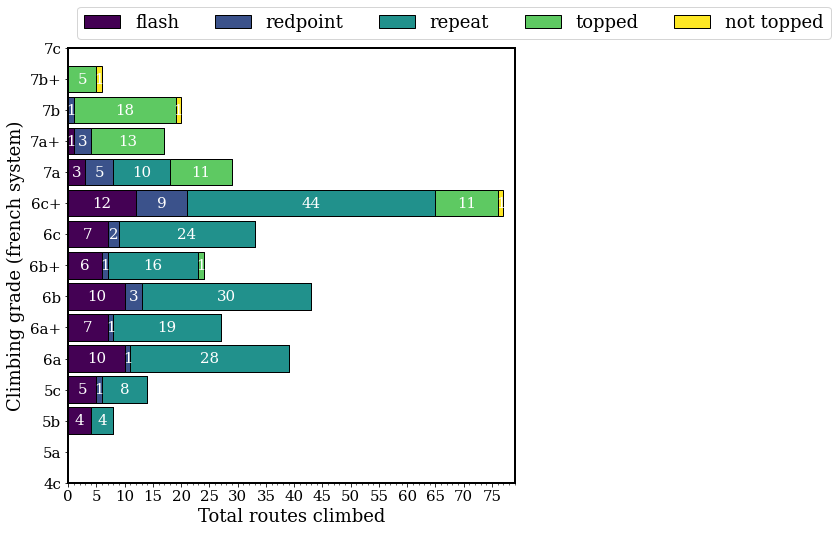

In [7]:
fig = plot_gradepyramid(logs, aggtype='sum', gradesystem='french', legend=True)

Text(34.0, 5.12a, '')

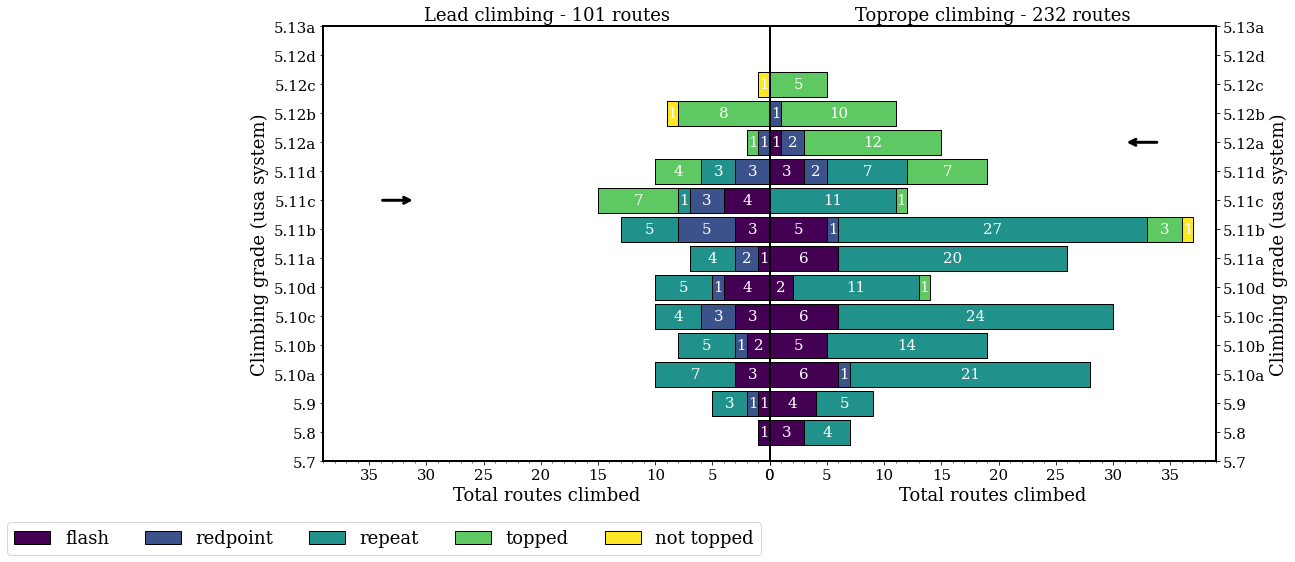

In [8]:
fig = plot_doublegradepyramid(logs, aggtype='sum', gradesystem='usa')
ax1, ax2 = fig.get_axes()
x1max = ax1.get_xlim()[0]
x2max = ax2.get_xlim()[-1]
ax1.annotate("", 
             xy=(x1max - 8, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='usa')),
             xytext=(x1max - 5, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='usa')),
             arrowprops=dict(arrowstyle="->", lw=3))
ax2.annotate("", 
             xy=(x2max - 8, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='usa')),
             xytext=(x2max - 5, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='usa')),
             arrowprops=dict(arrowstyle="->", lw=3))

In [ ]:
fig = plot_doublegradepyramid(logs, aggtype='sum', gradesystem='french')
ax1, ax2 = fig.get_axes()
x1max = ax1.get_xlim()[0]
x2max = ax2.get_xlim()[-1]
ax1.annotate("", 
             xy=(x1max - 8, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='french')),
             xytext=(x1max - 5, get_maxgrade_flash(logs[logs['style'] == 'lead'], gradesystem='french')),
             arrowprops=dict(arrowstyle="->", lw=3))
ax2.annotate("", 
             xy=(x2max - 8, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='french')),
             xytext=(x2max - 5, get_maxgrade_flash(logs[logs['style'] == 'toprope'], gradesystem='french')),
             arrowprops=dict(arrowstyle="->", lw=3))

Text(46.0, 7a+, '')

### 3. Plot weekly summary figure

In [ ]:
fig = plot_weeklysummary(logs, gradesystem='french')

In [ ]:
fig = plot_monthlysummary(logs, gradesystem='french')

In [ ]:
fig = plot_monthlysummary(logs, gradesystem='usa')

In [ ]:
fig = plot_weeklysummary(logs, gradesystem='usa')

### 4. Further testing

In [ ]:
pyrm = (logs[logs['ascension_type'] == 'redpoint']
        .groupby(['week', 'grade_french'])
        .agg(sends=('sends', 'sum'),
            )
       )

temp = (logs[logs['ascension_type'] == 'redpoint']
        .groupby('week')
        .agg(sends_total=('sends', 'sum'),
            )
       )

# Join the two dataframes
pyrm = pyrm.reset_index()
temp = temp.reset_index()

pyrm = pyrm.merge(temp, on=['week'], how='left')

pyrm['sends_percentage'] = pyrm['sends'] / pyrm['sends_total']
pyrm.loc[:, 'sends_percentage'] = pyrm.loc[:, 'sends_percentage'].fillna(0.)

# Perform pivot
pyrm = pyrm.pivot(index='grade_french', columns='week', values='sends_percentage')

pyrm = pyrm.drop(index=['1', '2', '3', 
                        '7c+', '8a', '8a+', '8b',
                       ])

pyrm

import seaborn as sns

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
sns.heatmap(pyrm, cmap='Blues', ax=ax)
ax.invert_yaxis()

In [ ]:
pyrm = (logs[logs['ascension_type'] == 'flash']
        .groupby(['date', 'grade_french'])
        .agg(sends=('sends', 'sum'),
            )
       )

temp = (logs[logs['ascension_type'] == 'flash']
        .groupby('date')
        .agg(sends_total=('sends', 'sum'),
            )
       )

# Join the two dataframes
pyrm = pyrm.reset_index()
temp = temp.reset_index()

pyrm = pyrm.merge(temp, on=['date'], how='left')

pyrm['sends_percentage'] = pyrm['sends'] / pyrm['sends_total']
pyrm.loc[:, 'sends_percentage'] = pyrm.loc[:, 'sends_percentage'].fillna(0.)

# Perform pivot
#pyrm = pyrm.pivot(index='grade_french', columns='date', values='sends_percentage')
pyrm = pyrm.pivot(index='grade_french', columns='date', values='sends')

pyrm = pyrm.drop(index=['1', '2', '3', 
                        '7c+', '8a', '8a+', '8b',
                       ])

pyrm

import seaborn as sns

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
sns.heatmap(pyrm, cmap='Blues', ax=ax)
ax.invert_yaxis()

In [ ]:
from matplotlib import rc, rcParams
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc("lines", markeredgewidth=2.0)
rc("axes", linewidth=2.0)
rc('font', family='serif')
rcParams["font.size"] = 15
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 8, width_ratios=[1,1,1,1,1,1,1,1])
ax = fig.add_subplot(gs[0,:7])
axcb = fig.add_axes(gs[0,7].get_position(fig))

pos = ax.imshow(pyrm.values, cmap='Blues', interpolation='none', aspect='auto', origin='lower')

cbar = fig.colorbar(pos, cax=axcb, format='%1.1f')
cbar.set_label('Percentage of routes during session')

ax.xaxis.set_major_locator(FixedLocator([ii for ii in range(pyrm.shape[1])]))
ax.yaxis.set_major_locator(FixedLocator([ii for ii in range(pyrm.shape[0])]))
ax.set_xticklabels([val.strftime('%Y-%m-%d') for val in pyrm.columns.to_list()],
                   rotation=90)
ax.set_yticklabels(pyrm.index.to_list())
ax.tick_params(axis='both',which='major',length=10,width=2)

axcb.grid(color='k')
axcb.tick_params(left='on')